In [21]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
!pwd

/kaggle/working


In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import PIL

In [12]:
input_path = "../input/alien-vs-predator/alien_vs_predator_thumbnails/data/"

# **Keras Data Generator**

In [13]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontconv_base = VGG16(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = Falseal_flip=True,
    validation_split=0.15,
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224),
    subset="training"
)

train_steps_per_epoch = train_generator.samples // train_generator.batch_size

validation_data = train_datagen.flow_from_directory(
    input_path + 'train',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224),
    subset="validation"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    input_path + 'validation',
    batch_size=16,
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

test_steps_per_epoch = test_generator.samples // test_generator.batch_size


Found 590 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# **Creating Network**

In [14]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


# **Adding Layers**

In [15]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

predictions = layers.Dense(2, activation='softmax')(x)
model = keras.Sequential()
model = Model(inputs = conv_base.input, outputs = predictions)

# **Saving the model checking val_loss value**

In [16]:
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)

# **Compiling Model with Adam Optimizer**

In [18]:
optimizer = keras.optimizers.Adam(lr = 0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# **Training the model**

In [19]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_steps_per_epoch, 
                              epochs=35,
                              validation_data=validation_data,
                              validation_steps=10,
                              callbacks = [model_save]
                             )

Epoch 1/35
36/36 [==============================] - 14s 280ms/step - loss: 0.7741 - accuracy: 0.6013 - val_loss: 0.1789 - val_accuracy: 0.9519

Epoch 00001: val_loss improved from inf to 0.17893, saving model to weights.h5
Epoch 2/35
36/36 [==============================] - 7s 180ms/step - loss: 0.3108 - accuracy: 0.8655
Epoch 3/35
36/36 [==============================] - 7s 189ms/step - loss: 0.2529 - accuracy: 0.8807
Epoch 4/35
36/36 [==============================] - 6s 176ms/step - loss: 0.2338 - accuracy: 0.9238
Epoch 5/35
36/36 [==============================] - 7s 201ms/step - loss: 0.1837 - accuracy: 0.9294
Epoch 6/35
36/36 [==============================] - 7s 191ms/step - loss: 0.1888 - accuracy: 0.9222
Epoch 7/35
36/36 [==============================] - 7s 185ms/step - loss: 0.1741 - accuracy: 0.9331
Epoch 8/35
36/36 [==============================] - 7s 191ms/step - loss: 0.1633 - accuracy: 0.9361
Epoch 9/35
36/36 [==============================] - 7s 185ms/step - loss: 0.1

# **Making predictions on sample test images**

In [22]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [23]:
validation_img_paths1 = ["validation/alien/24.jpg",
                        "validation/alien/23.jpg",
                        "validation/predator/5.jpg"]
img_list1 = [Image.open(input_path + img_path) for img_path in validation_img_paths1]

In [24]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [27]:
validation_batch1 = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list1])

In [25]:
pred_probs = model.predict(validation_batch)
pred_probs

array([[9.7933805e-01, 2.0662019e-02],
       [9.9987602e-01, 1.2393063e-04],
       [1.0407963e-03, 9.9895918e-01]], dtype=float32)

In [28]:
pred_probs1 = model.predict(validation_batch1)
pred_probs1

array([[9.9955064e-01, 4.4932595e-04],
       [9.8924571e-01, 1.0754219e-02],
       [2.6550638e-03, 9.9734491e-01]], dtype=float32)

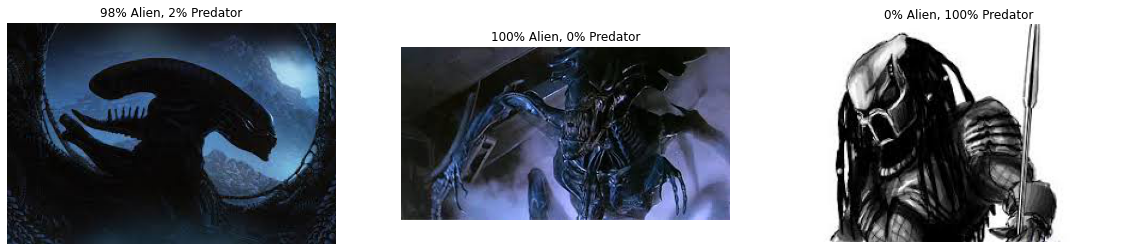

In [29]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

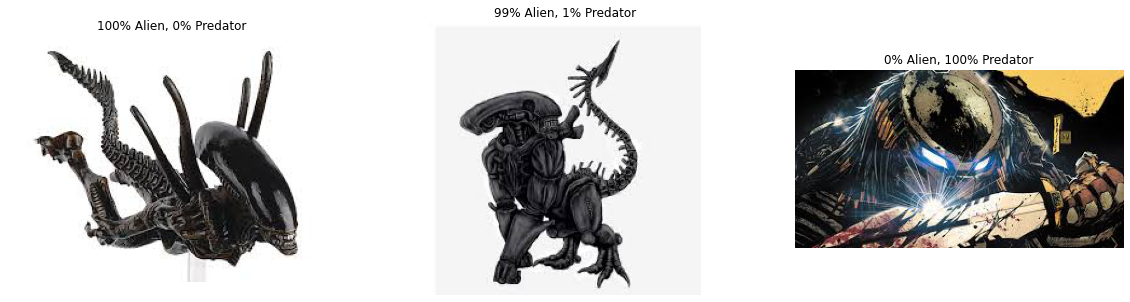

In [30]:
fig1, axs1 = plt.subplots(1, len(img_list1), figsize=(20, 5))
for i, img in enumerate(img_list1):
    ax = axs1[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs1[i,0],
                                                            100*pred_probs1[i,1]))
    ax.imshow(img)

# **Accuracy**

In [31]:
prediction = model.predict_generator(test_generator, steps=(test_steps_per_epoch+1))
prediction = prediction.argmax(axis=-1)

count = 0
for i in range(len(prediction)):
    if (test_generator.classes[i] == prediction[i]):
        count+=1
        
print("Accuracy = ", count/len(prediction) * 100.0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy =  93.0


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


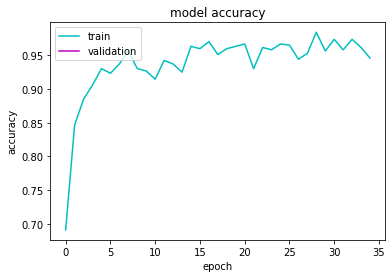

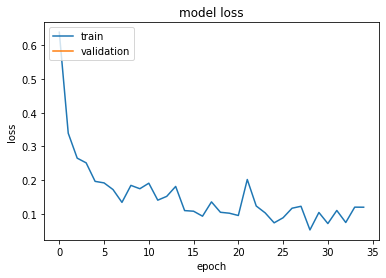

In [33]:
print(history.history.keys())
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Confusion Matrix
[[89 11]
 [ 3 97]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.96739   0.89000   0.92708       100
           1    0.89815   0.97000   0.93269       100

    accuracy                        0.93000       200
   macro avg    0.93277   0.93000   0.92989       200
weighted avg    0.93277   0.93000   0.92989       200



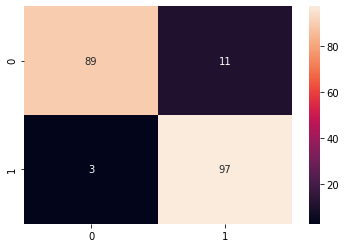

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, prediction)
print(cm)
print(sns.heatmap(confusion_matrix(test_generator.classes, prediction),annot=True,fmt="d"))
print(classification_report(test_generator.classes, prediction, digits=5))